## EDA

In [1]:
import os
from ipywidgets import interact, widgets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')

### Config

In [2]:
if "chdir_done" not in globals():
    os.chdir("..")
    chdir_done = True

work_directory = os.getcwd()

### Constants

In [3]:
headers = {
    "selector": "th.col_heading",
    "props": "background-color: #7a7adf; color: white;",
}
index_style = {
    "selector": "th.index_name",
    "props": "background-color: #7a7adf; color: white;",
}

In [4]:
CLEAN_FILE = "data/clear_data.pkl"

### Импорт и проверка данных

In [5]:
df_ecom = pd.read_pickle(CLEAN_FILE)

In [6]:
df_ecom.head()

,user_id,product_id,category,price,discount,final_price,payment_method,purchase_date,purchase_month
2920,9a4c4cd0,e3c44ef7-d,Home & Kitchen,118.84,25,89.13,Debit Card,2024-01-01,2024-01-01
2953,d9c0aa17,a8aaaab9-c,Electronics,30.69,10,27.62,Debit Card,2024-01-01,2024-01-01
782,c44db413,e1224f77-9,Electronics,304.33,50,152.16,Credit Card,2024-01-01,2024-01-01
2459,5d42a5ff,1791f55a-d,Sports,190.85,15,162.22,Net Banking,2024-01-01,2024-01-01
1062,dabe2577,44399f1d-0,Beauty,329.64,15,280.19,Credit Card,2024-01-01,2024-01-01


In [7]:
df_ecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3660 entries, 2920 to 3469
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3660 non-null   object        
 1   product_id      3660 non-null   object        
 2   category        3660 non-null   object        
 3   price           3660 non-null   float64       
 4   discount        3660 non-null   int64         
 5   final_price     3660 non-null   float64       
 6   payment_method  3660 non-null   object        
 7   purchase_date   3660 non-null   datetime64[ns]
 8   purchase_month  3660 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 285.9+ KB


#### Проверка на пропуски

In [8]:
df_ecom.isnull().sum()

user_id           0
product_id        0
category          0
price             0
discount          0
final_price       0
payment_method    0
purchase_date     0
purchase_month    0
dtype: int64

<div class="alert alert-success">
    <strong>Итого</strong>: Пропусков нет
</div>

#### Проверка на дубликаты

In [9]:
df_ecom.duplicated().sum()

np.int64(0)

<div class="alert alert-success">
    <strong>Итого</strong>: Дубликатов нет
</div>

### Описание данных

In [10]:
df_ecom.describe()

,price,discount,final_price,purchase_date,purchase_month
count,3660.000000,3660.000000,3660.000000,3660,3660
mean,254.800675,18.825137,206.906579,2024-06-13 00:46:01.967213056,2024-05-29 09:28:07.868852480
min,10.090000,0.000000,5.890000,2024-01-01 00:00:00,2024-01-01 00:00:00
25%,134.012500,5.000000,104.512500,2024-03-24 00:00:00,2024-03-01 00:00:00
50%,253.845000,15.000000,199.185000,2024-06-11 12:00:00,2024-06-01 00:00:00
75%,377.595000,25.000000,304.117500,2024-09-03 00:00:00,2024-09-01 00:00:00
max,499.960000,50.000000,496.820000,2024-11-21 00:00:00,2024-11-01 00:00:00
std,141.682621,14.731338,122.687844,NaN,NaN


#### Итого обработки данных

- В ценах на первый взгляд значительного отклонения не наблюдается
- Скидки также адекватные. И более 50% скидка не предоставлялась
- Данные представлены с `2024-01-01` по `2024-11-21`

---

### Категориальные данные

In [11]:
df_ecom.describe(include="all")[["category", "payment_method"]].dropna()

,category,payment_method
count,3660,3660
unique,7,5
top,Home & Kitchen,Credit Card
freq,549,760


Представлено 7 категорий и 5 методов оплаты

#### Анализ категорий

In [12]:
pd.concat(
    [
        df_ecom["category"].value_counts(),
        df_ecom["category"].value_counts() / df_ecom["category"].count(),
    ],
    axis=1,
).reset_index().set_axis(["category", "sales", "per_of_sales"], axis=1).style.format(
    {"per_of_count": "{:,.2%}".format}
).format_index(
    str.upper, axis=1
).set_table_styles(
    [headers, index_style]
)

,CATEGORY,SALES,PER_OF_SALES
0,Home & Kitchen,549,0.150000
1,Books,534,0.145902
2,Clothing,531,0.145082
3,Toys,523,0.142896
4,Sports,520,0.142077
5,Beauty,505,0.137978
6,Electronics,498,0.136066


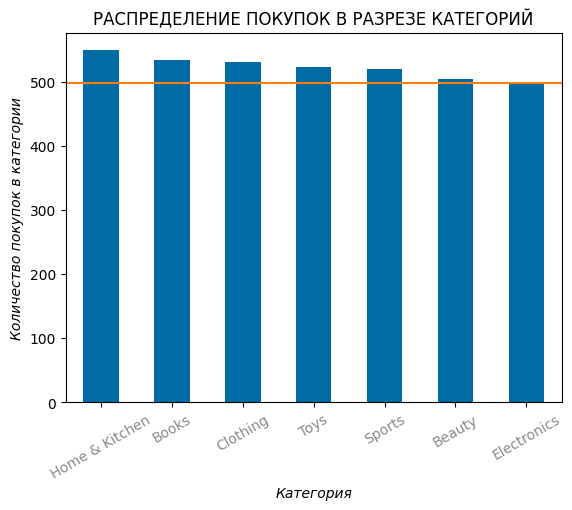

In [13]:
df_ecom["category"].value_counts().plot(kind="bar")

plt.axhline(df_ecom["category"].value_counts().min(), color="C1")
plt.title(
    "Распределение покупок в разрезе категорий".upper(),
    fontdict={"fontsize": 12, "color": "black"},
)
plt.xlabel("Категория", fontstyle='italic')
plt.ylabel("Количество покупок в категории", fontstyle='italic')
plt.xticks(rotation = 30, color = 'C6')
plt.show()

Мы видим, что в целом покупки имеют одинаковое распределение. \
Построим теперь покупки по категориям в динамике

In [14]:
all_category = df_ecom.category.unique()
count_category = len(all_category)

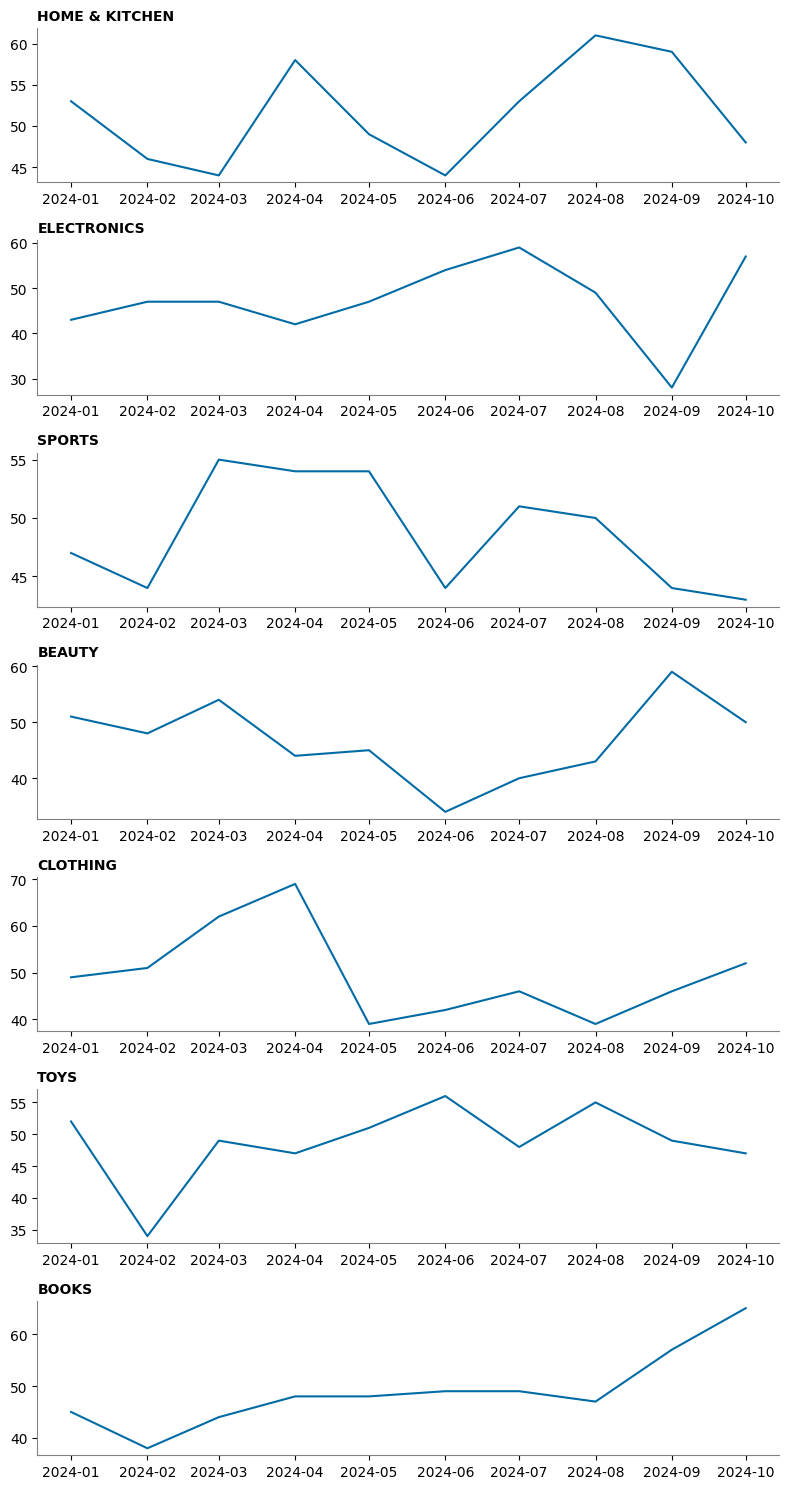

In [15]:
plt.figure(figsize=(8, 15))
for n, category in enumerate(all_category, start=1):
    plt.subplot(count_category, 1, n)
    plt.title(category.upper(), loc="left", fontweight="bold", fontsize=10)

    sns.lineplot(
        df_ecom.groupby(
            by=["category", df_ecom["purchase_date"].dt.to_period("M").dt.start_time]
        )["user_id"]
        .count()
        .reset_index()
        .rename(columns={"user_id": "sales"})
        .query("category == @category and purchase_date < '2024-11-01'"),
        x="purchase_date",
        y="sales",
    )

    plt.xlabel("")
    plt.ylabel("")

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines[:].set_color("grey")

plt.tight_layout()

Для построения графиков по месяцам был исключён ноябрь, так как этот месяц является неполным

<div class="alert alert-success">
    <strong>Итого</strong>: 

- Исходя из графиков более менее стабильный спрос у электроники и в игрушках
- В книгах идёт также тренд на повышение
- В остальных категориях скорее всего большую роль играют сезонные факторы
</div>

In [16]:
df_ecom.user_id.duplicated().sum()

np.int64(0)

In [17]:
df_ecom.product_id.duplicated().sum()

np.int64(0)

Когортный анализ нет смысла делать, так как нету повторений в user_id и product_id

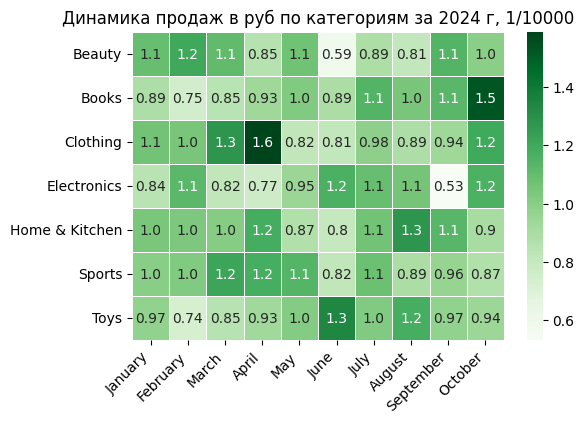

In [18]:
plt.figure(figsize = (6,4))
ax = sns.heatmap(
    data=df_ecom.query('purchase_month < "2024-11-01"').pivot_table(
        index="category",
        columns="purchase_month",
        values="final_price",
        aggfunc="sum",
    ) / 10000,
    cmap='Greens',
    linewidths=.5,
    annot=True,
    fmt='.2'
)

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('Динамика продаж в руб по категориям за 2024 г, 1/10000')

month_labels = (
    df_ecom.query('purchase_month < "2024-11-01"')["purchase_month"]
    .sort_values()
    .dt.strftime("%B")
    .unique()
)

ax.set_xticklabels(month_labels, rotation=45, ha="right")
plt.show()

<div class="alert alert-success">
    <strong>Итого</strong>: 

- Мы можем наблюдать, что пока не на все категории есть устойчивый спрос
- Особенно это видно по электронике, которая в сентябре почти не продавалась, в отличие от других категорий
- Также видим вещи, у которых наблюдается существеенный рост до апреля, а затем падение
</div>

In [19]:
def get_plot_distribution(category):
    ax = sns.catplot(
        data=df_ecom.query('category == @category').sort_values(by="purchase_month"),
        x="purchase_month",
        y="final_price",
        kind="boxen",
    )
    ax.set_xticklabels(rotation=45)
    ax.set_xlabels("")
    ax.set_ylabels("Цена продажи")
    plt.show()

category_selector = widgets.Dropdown(
    options=df_ecom["category"].unique(),
    description="Категория:",
)

In [20]:
interact(get_plot_distribution, category=category_selector);

interactive(children=(Dropdown(description='Категория:', options=('Home & Kitchen', 'Electronics', 'Sports', '…

График может не отображаться, если смотреть его на github

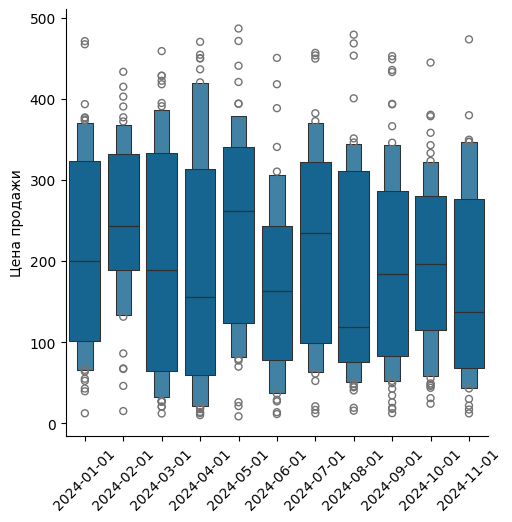

In [21]:
get_plot_distribution('Beauty')

<div class="alert alert-success">
    <strong>Итого</strong>: 

- Мы видим что медианная цена в целом менялась хаотично
- Исключения можно найти разве только в Beauty
</div>

In [22]:
df_ecom_month = df_ecom.groupby(by='purchase_date', as_index=False)['final_price'].sum()

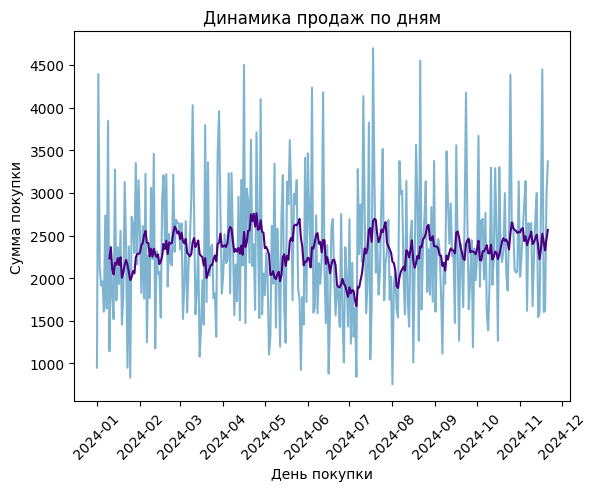

In [23]:
ax = sns.lineplot(data=df_ecom_month, x="purchase_date", y="final_price", alpha=0.5)
sns.lineplot(
    y=df_ecom_month.final_price.rolling(10).mean(),
    x=df_ecom_month.purchase_date,
    color="indigo",
)
plt.xticks(rotation=45)
plt.title('Динамика продаж по дням')
plt.xlabel('День покупки')
plt.ylabel('Сумма покупки')
plt.show()